# Topic Categorization with converstation thread effects

When detecting topics in a document, common ways include simple *keyword* matching, *topic modeling*, and many others. While this works fine for large text documents like news articles, applying this type of approach to social media data has a serious *methodological* flaw: posts are not isolated but usually part of a conversation thread. Hence if one post is detected as being on the topic, it is logical that another post that replies to it is also on the topic, however this second post might not have used *keywords* that resulted in being detected and tagged as on the topic. 

This notebook walks through the problem and proposes a basic model using Twitter data. It shows how conversation thread affects can be used with an existing list of *pre-categorized* tweets to expand the number of tweets that are coded as being on the topic.

## The problem space 

On Twitter, we can consider that there are 3 potential scenarios for tweets in the context of a convesation thread:
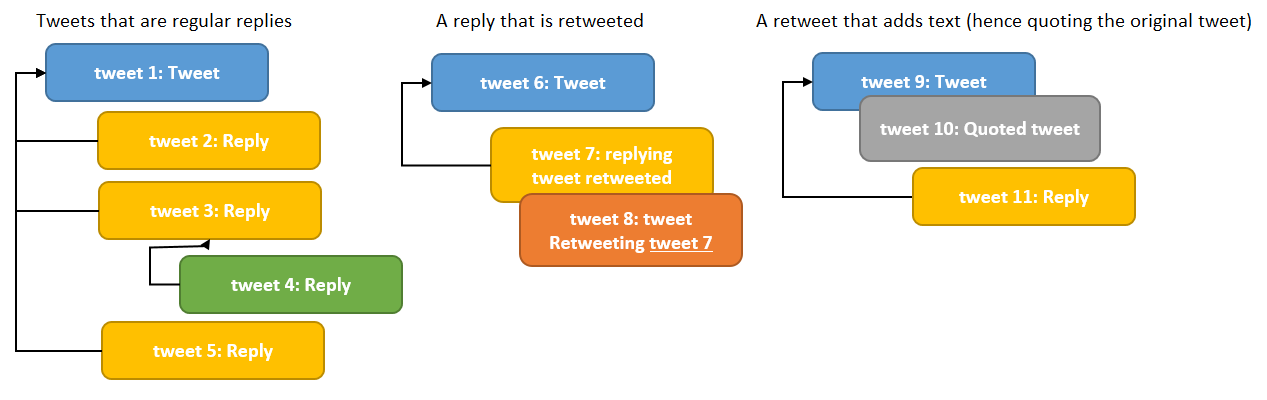

1. **Topics flow down in threads, not up**: the first scenario is quite simple, a tweet replies to another tweet. So for instance, if **tweet 1** is categorized as being on a certain topic, then logically every replying tweet is also on the topic (**tweets 2-5**). 
    * If **tweet 3** is on the topic, then **tweet 4** is as well, but not the others (**1, 2, or 5**)
    * *NOTE*: This is obviously a bit of a simplification and depends on how a topic is defined. A reply can be on a separate topic, especially if the topics being analyzed are quite close logically, then the transition is harder to determine. More on this later...
   
2. **How Twitter stores replies for retweeted tweets impacts how we categorize RTs**: Twitter stores a reply relationship in the original (i.e. retweeted) tweet, not the tweet that retweeted it. As we often investigate tweet topics by also including the tweets that retweeted others as copies of the original, we need to take this into account.
    * In other words, say we want to create a picture of the topics that were discussed during a particular day. We would pull all the tweets and then pull all the retweets that were made during that day, and plot them by topic per hour. This means that we pull the `retweet tweet id`, `retweet created at`, and `retweeted tweet text`. In this case, we need to check if the retweeted tweet was a reply to another tweet that was determined to be on a specific topic!
    
3. **Adding text/comment while retweeting also has to be taken into account**: if a user retweets a tweet, they have the option to *Retweet with comment* --which is stored by Twitter as a separate tweet but is linked (and displayed) with the retweeted tweet as embedded below. In the Twitter API, the retweeted tweet is called a `quoted_status`. Hence if a *quoted tweet*, for instance **tweet 10** is categorized on the topic, then the *commenting tweet* or **tweet 9**, must also be on the topic
    

## Conceptual solution

As such we have 4 inputs:
* a list of tweets with their ids and topics: `list_tweets = [('twtid','topic'),..]`
* a list of tweets that reply to other tweets: `list_replies = [('twtid','inreplytotwtid'),...]`
* a list of retweeted tweet ids that retweeted a previous tweet: `list_rts = [('twtid','rttwtid'),...]`; and
* a list of quotes, i.e. when one tweet quoted another: `list_quotes = [('twtid','qttwtid'),...]`

The output should be a final list of tweets with the topics changed: `recategorized_tweet_list = [('twtid','topic'),..]`

*NOTE*, for simplicity, the rest of the walkthorugh will consider only 2 topics, or whether the tweet is on a specific topic or not.

-------------------------

Conceptually, there are **two ways** to solve the problem:
1. Using the tweets that **are categorized** about the topic
    * In other words, for each tweet that is a about a topic, use the conversation thread linkages based on certain rules to tag all related or **downstream** tweets as also about the topic. This will mean that a conversation thread is *virtually* created for each tweet coded about the topic.
2. The reverse, starting with the tweets **not categorized** as about the topic
    * This approach will require an iteration through all uncategorized tweets, checking each that the rules and conversation thread linkages allow the tweet to be recategorized as about the topic. This step is repeated again and again until tweets are **no longer** being recategorized. 
    
While a thorough test of efficiency is required, option 1 requires building a conversation thread *object* first, and using it to categorize tweets. As a method does not exist, this will be done in a later section. *(Note, some like @fionapigott have created [conversation thread builders](https://github.com/fionapigott/conversation-builder), but they only work with *replies*, and not *quotes*, as there is often an interelation of quotes that starts separate conversation threads)*

This workbook will thus follow the 2nd option in solving the problem

## Model

The model will be based on the following steps/rules:
1. Create a dictionary for each convesation relationship, such as `replies_dict = {'twtid':'inreplytotwtid',...}`
2. Create a dictionary for all tweets within the sample, and a sub-dictionary that contains the necessary parameters (topic, etc). For instance `tweet_dict = {'twtid':{'topic':'protests','twt_text':'bla bla bla','userid':'123456'}, ...}`
3. Iterate through all tweets **not** on the topic, and using the convesation relationships from #1, find the the tweets that each tweet refers to (i.e. the *parent* to the *child*)
4. Use the dictionary of tweets and topics from #2, to check which topic the *parent* tweet is on, and if its on the topic, change the topic of the *child*
5. Continue until no more tweets are recategorized with each loop

In [14]:
class ConvoTopic:
    """
    ConvoTopic changes the topic of tweets not categorized about a topic to the topic by 
    checking the conversation thread affects.  
    """
    def __init__(self, 
                 retweet_list,
                 reply_list, 
                 quote_list):
        """
        @parameters:
        - retweet_list - list of retweets in the manner of [('tweet id','retweeted tweet id'),...]
        - reply_list - list of all replies in the manner of [('tweet id','replyng to tweet id'),...]
        - quote_list - list of all times a quote is made, [('tweet id','quoting tweet id'),...]
        """
        self.replies = {each[0]:each[1] for each in reply_list}
        self.quotes = {each[0]:each[1] for each in quote_list}
        self.retweets = {each[0]:each[1] for each in retweet_list}

    #----------------------main function--------------------------------------------------------------------------------
    def Recategorize_one_topic(self, tweet_list, change_topic_label, no_topic_label="NA"):
        """
        Check and recategorize the tweets NOT about the topic but should be
        
        @parameter:
            - tweet_list - list of tweets with tuples, such as [('twtid','topic',...),...]
                NOTE the first must be the tweet id, the second the topic label, further inputs are ignored and returned as is
            - no_topic_label - what is the label of topics that have no label associated with them. 
                default - 'NA'
        @returns: dict of tweets and their topics 
        """
        self.change_topic_label = change_topic_label
        #first, just run the regular categorization and categorize based on keyword matches
        if len(tweet_list[0]) > 2:
            self.initial_tweet_dict = {each[0]:{'topic':each[1],'other_params':[each[2:]]} for each in tweet_list}
        else:
            self.initial_tweet_dict = {each[0]:{'topic':each[1]} for each in tweet_list}
        self.no_topic_label = no_topic_label
        return self._recategorize_mast_()
        
    #----------------------supporting functions--------------------------------------------------------------------------
    def _recategorize_mast_(self):
        """
        main function that recagorizes tweets based on the initial input of tweets
        """
        #create a copy of the original tweet dict to work with
        tweet_dict = self.initial_tweet_dict.copy()
        i = 1
        while True:
            n_changed = 0
            #iterate over all the tweets in the master input dict
            for tweet, value in self.initial_tweet_dict:
                #only check and change the topic if the topic was NOT on the topic of interest
                if value['topic'] == self.no_topic_label:
                    result = self._recategorize_check_tweet_(tweet)
                    if result == "change":
                        tweet_dict[tweet]['topic'] == self.change_topic_label
                        n_changed += 1
            print("{i} iteration completed, recategorized this round: {n}".format(i=i,n=n_changed))
            i += 1
            #if no more tweets are being changed, exit the loop
            if n_changed == 0:
                break
        return new_tweet_list
    
    def _recategorize_check_tweet_(self, twtid):
        """
        check the tweet that is inputted as about the applicable rules
        """
        #default 'result' of the check is None. If a match is made with any of the convo links, then 'result' is updated. 
        result = None
        #check replies -- if this tweet was a reply to the other tweet
        if twtid in self.replies and self.replies[twtid] in self.initial_tweet_dict:
            #check if the topic of the replied to tweet was on the topic we are listening to
            if self.initial_tweet_dict[self.replies[twtid]]['topic'] == self.change_topic_label:
                result = "change"
        #check quotes -- if this tweet quoted another tweet
        if twtid in self.quotes and self.quotes[twtid] in self.initial_tweet_dict:
            #now check if the topic of the quoted tweet was on the topic of interest 
            if self.initial_tweet_dict[self.quotes[twtid]]['topic'] == self.change_topic_label:
                result = "change"
        #check retweets -- if this tweet retweeted another tweet
        if twtid in self.retweets and self.retweets[twtid] in self.initial_tweet_dict:
            #if the retweeted tweet was on the topic, then change the retweeting tweet topic
            if self.initial_tweet_dict[self.retweets[twtid]]['topic'] == self.change_topic_label:
                result = "change"
        return result

Great! That should be sufficient. Now we need to prepare some data to feed it and test it:
1. Categorize some tweets about a topic
2. Prepare the `replies`, `retweets`, and `quotes` lists

### 1. Get some data and pre-categorize tweets as about a topic

In [2]:
import pandas as pd
from nlpru import Cleaner
from nltk.tokenize import word_tokenize
from nltk import FreqDist

from pysqlc import DB
db = DB('kremlin_tweets_db')

Successfully connected to kremlin_tweets_db database


*NOTE*, for this example, I am using a pre-normalized data saved in a MySQL server on a *database* called *kremlin_tweets_db*. For more information about this topic, please see our paper [*"Kremlin Tweets: the politics of social media and the quest for legitimacy in Putin’s Russia"*](https://www.rudatalab.com/analysis/); or about the normalizing methodology, see the [db schema](https://github.com/sergegoussev/Twitter_analysis/tree/master/SQL) and [normalizing script here](https://github.com/sergegoussev/Twitter_analysis/blob/master/Python/_MySQL_CategorizeNSave3.py). 

In [3]:
#initiate the Cleaner from nlpru
C = Cleaner()
    
def __get_data__(start_date, end_date, twt_createdat=False, communities=False):
    """
    Isolate the get data portion into a sepearate query (for easier use later)
    
    There are 2 options built into the script:
        - twt_createdat -- if True, then the time stamp of the tweet will be included
        - communities -- if included, then they will be listed for each user (under tweet)
    """
    #first get create the SQL query that will collect the data. 
    #As we will need the FreqDist, we want the retweeted text as well so we do a UNION
    if twt_createdat == False:
        twt_createdat_string = ""
    elif twt_createdat == True:
        twt_createdat_string = ", twt_createdat"
    if communities == False:
        c_column = ""
        c_tables = ""
    elif communities == True:
        c_column = ", imrev3"
        c_tables = """
        
    LEFT JOIN meta_all_users_communities com
    ON tmast.userid=com.userid
        """
    q = """
     SELECT 
        tmast.twttext as twttext,
        tsamp.twtid,
        tmast.userid{twt_createdat_string}{c_column}
    FROM samp_twts_all_rus_twts_str tsamp 
        INNER JOIN twt_Master tmast 
        ON tsamp.twtid=tmast.twtid{c_tables} 

    WHERE tmast.twt_lang='ru'  
    AND tmast.twt_createdat >= '{start}'
    AND tmast.twt_createdat < '{end}'

    UNION ALL

    SELECT
        tmast.twttext AS twttext,
        tsamp.twtid,
        trts.userid{twt_createdat_string}{c_column}
    FROM samp_twts_all_rus_twts_str tsamp
        INNER JOIN twt_rtmaster trts
        ON tsamp.twtid=trts.twtid
        INNER JOIN twt_master tmast
        ON trts.rttwtid=tmast.twtid{c_tables}

    WHERE tmast.twt_lang='ru' 
    AND tmast.twt_createdat >= '{start}'
    AND tmast.twt_createdat < '{end}';
    """.format(start=start_date,
               end=end_date,
               twt_createdat_string=twt_createdat_string,
               c_column=c_column,
               c_tables=c_tables)
    raw = db.query(q)
    print("There are {:,} tweets in the captured sample!".format(len(raw)))
    return raw

def __check_words_in_doc__(document):
    """
    isolate the checking of words from a document into a separate function (for easier use later)
    """
    words = []
    for word in word_tokenize(document):
        result = C.Check_word(word, remove_proper_nouns=False)
        if result['status'] == 'ok':
            words.append(result['word'])
    return words

In [4]:
start_date='2017-03-26'
end_date='2017-03-27'
raw = __get_data__(start_date=start_date, end_date=end_date, twt_createdat=True, communities=True)

There are 44,613 tweets in the captured sample!


Now add some keywords and classify this data as *about* a topic or *not* based on a match of **at least one** keyword:

In [5]:
#Lets say we pick the following keywords:
keywords1 = "россия, москва, митинг, навальный, задержать, против, акция, полицейский, димонответить, димон, протест, коррупция"
keywords = keywords1.split(", ")

In [6]:
final_list_of_tweets = []
for tweet in raw:
    clean_words = __check_words_in_doc__(tweet[0])
    if len(set(keywords).intersection(clean_words)) != 0:
        topic = "Protests"
    else:
        topic = "others"
    final_list_of_tweets.append((tweet[3], topic, tweet[0], clean_words, tweet[1], tweet[2]))

In [7]:
df = pd.DataFrame(final_list_of_tweets, columns=["twt_createdat","Topic","Tweet","Clean words","twtid","userid"])
df[["twt_createdat","Topic"]].groupby("Topic").count()/df["twt_createdat"].count()*100

,twt_createdat
Topic,
Protests,15.123395
others,84.876605


Alright, so now we have a set of 44,613 tweets, and we know that aprox 15% of them are categorized as being about the topic we picked based on keywords. 

### 2. Prepare the conversation thread linkages

Get the *list of replies* for this sample and date range

In [8]:
repl_q = """
SELECT 
    repl.twtid, 
    inreplytotwtid
FROM meta_repliesmaster repl
    INNER JOIN samp_twts_all_rus_twts_str samp
    ON repl.twtid=samp.twtid
    
    INNER JOIN twt_master tm
    ON tm.twtid=repl.twtid
    
WHERE tm.twt_createdat >= '{start_date}'
AND tm.twt_createdat < '{end_date}'
""".format(start_date=start_date, end_date=end_date)
reply_list = db.query(repl_q)

Now get the *retweets* for this sample and date range

In [9]:
retweet_q = """
SELECT 
    rt.twtid,
    rttwtid
FROM twt_rtmaster rt
    INNER JOIN samp_twts_all_rus_twts_str samp
    ON rt.twtid=samp.twtid
    
WHERE rt.rt_createdat >= '{start_date}'
AND rt.rt_createdat < '{end_date}'
""".format(start_date=start_date, end_date=end_date)
retweet_list = db.query(retweet_q)

Now get the *quotes* for this sample and the date range

In [10]:
quote_q = """
SELECT 
    qt.twtid,
    qttwtid
FROM twt_qtmaster qt
    INNER JOIN samp_twts_all_rus_twts_str samp
    ON qt.twtid=samp.twtid
    
    INNER JOIN twt_master tm
    ON tm.twtid=qt.twtid
    
WHERE tm.twt_createdat >= '{start_date}'
AND tm.twt_createdat < '{end_date}'
""".format(start_date=start_date, end_date=end_date)
quote_list = db.query(quote_q)

## Test the model

Now that all data is assembled, lets try to run the model and see what we get

In [16]:
T = ConvoTopic(
    retweet_list = retweet_list,
    reply_list = reply_list,
    quote_list = quote_list
)

In [21]:
# T.Recategorize_one_topic(
#     tweet_list=final_list_of_tweets,
#     change_topic_label = "Protests",
#     no_topic_label = "others"
# )
initial_tweet_dict = {each[0]:{'topic':each[1],'other_params':[each[2:]]} for each in final_list_of_tweets}
len(final_list_of_tweets)

26034